In [1]:
from genre_classifier_cnn import build_model
import json
import numpy as np
from sklearn.model_selection import train_test_split

2023-05-30 21:19:41.155139: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-30 21:19:41.185772: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [11]:
DATASET_PATH = "data_gender.json"

In [12]:
def load_data(data_path):
    with open(data_path, "r") as fp:
        data = json.load(fp)
    
    # convert lists into numpy array
    inputs = np.array(data["mfcc"])
    targets = np.array(data["labels"])

    return inputs, targets

def prepare_datasets(test_size, validation_size):
    # load data
    x, y = load_data(DATASET_PATH)

    # create train/test split
    x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y, test_size=test_size, random_state=42, shuffle=True)

    # create train/validation split
    x_train, x_validation, y_train, y_validation = train_test_split(x_train, y_train,stratify=y_train, test_size=validation_size, random_state=42, shuffle=True)

    # 3d array (adds the "gray chanel" to the mfccs)
    x_train = x_train[..., np.newaxis] # 4d array -> (num_samples, 130, 13, 1)
    x_validation = x_validation[..., np.newaxis]
    x_test = x_test[..., np.newaxis]
    
    return x_train, x_validation, x_test, y_train, y_validation, y_test

def predict(model, x):

    classes = ['female', 'male']

    x = x[np.newaxis, ...]
    # prediction [[0.1, 0.2, ...]]
    prediction = model.predict(x) # x -> (1, 130, 13, 1)

    #extract idenx with max value
    predicted_index = np.argmax(prediction, axis=1) # [4]

    return predicted_index[0]

In [13]:
x_train, x_validation, x_test, y_train, y_validation, y_test = prepare_datasets(0.25, 0.2)
input_shape = (x_test.shape[1], x_test.shape[2], x_test.shape[3])

In [14]:
model = build_model(input_shape)
model.load_weights('./checkpoints/gender_classifier_checkpoint').expect_partial()

### Compute metrics

In [15]:
y_pred = []
y_gt = []
for i in range(len(y_test)):
    x = x_test[i]
    y_gt.append(y_test[i])
    y_pred.append(predict(model, x))
    

1/1 [==============================] - 0s 17ms/step


In [16]:
# calcular accuracy, precision, recall, f1-score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print(f"Accuracy: {accuracy_score(y_gt, y_pred)}")
print(f"Precision: {precision_score(y_gt, y_pred)}")
print(f"Recall: {recall_score(y_gt, y_pred)}")
print(f"F1-score: {f1_score(y_gt, y_pred)}")

Accuracy: 0.8771498771498771
Precision: 0.936768149882904
Recall: 0.8456659619450317
F1-score: 0.888888888888889


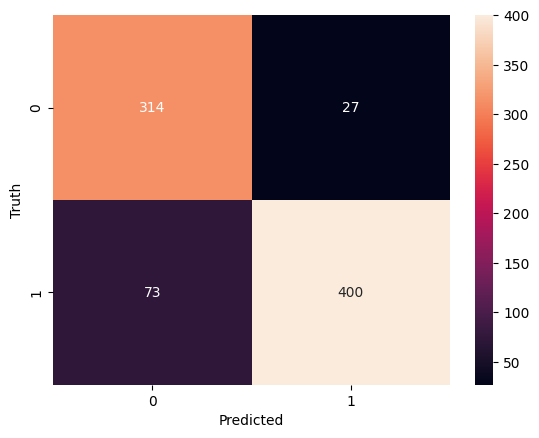

In [17]:
# calcular matriz de confusão
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_gt, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

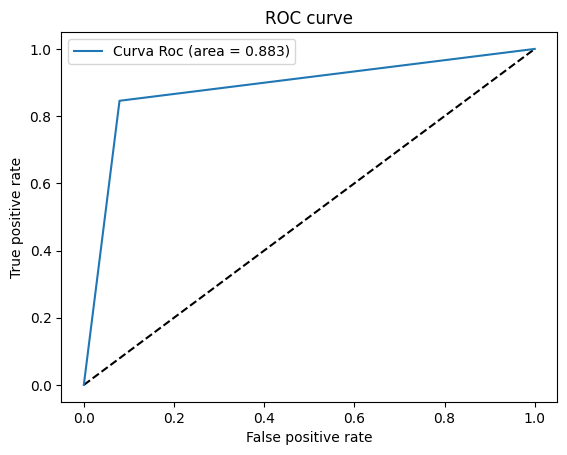

In [18]:
# calcular curva roc
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_gt, y_pred)
auc_keras = roc_auc_score(y_gt, y_pred)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label=f'Curva Roc (area = {auc_keras:.3f})')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()